# Importing the packages

In [76]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import random
import pathlib

import IPython.display as display


In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

# Importing the data


create a list of paths to all the images in the folder, and shuffling them

In [78]:
directory="/content/drive/My Drive/Columbia /2020 Fall/Applied Deep Learning/images/"
data_root=pathlib.Path(directory)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
#We shuffle the data
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

319

# Without data augmentation

### take the label information





In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['alma_mater_columbia', 'butler_library_columbia', 'lion_statue_columbia']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'alma_mater_columbia': 0,
 'butler_library_columbia': 1,
 'lion_statue_columbia': 2}

In [ ]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
print(all_labels[:10])

[0, 1, 0, 0, 0, 1, 0, 1, 1, 1]


### Create the training and testing sets

We will split the data in training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

In [ ]:
print("content of the training set")
print(np.sum([element==0 for element in train_labels])," images of the alma mater")
print(np.sum([element==1 for element in train_labels])," images of the butler library")
print(np.sum([element==2 for element in train_labels])," images of the lion statue")

content of the training set
101  images of the alma mater
81  images of the butler library
57  images of the lion statue


###building the function to read (create tensor) and show images

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [ ]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  plt.show()

###Creating tensorflow datasets

creating dataset for the paths, images and labels ( the map function allows parralel computation)

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)

image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))

concatenate the datasets to show image and label, .zip allows the concatenation

In [ ]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

Batch and shuffle

In [ ]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

## Creating the model 

CREating a model VGGNET without data augmentation

In [ ]:

from keras.layers import Dropout,BatchNormalization

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 433203    
Total params: 433,651
Trainable params: 433,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=15, validation_data=test_ds)

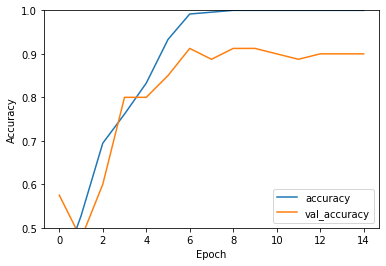

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
predictions=model.predict(test_ds)
predicted=np.array([np.argmax(predictions[i]) for i in range(len(predictions))])

In [ ]:
predicted

array([1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 1,
       0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2,
       2, 0, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [ ]:
label_predicted=[label_names[element] for element in predicted]

Prediction : alma_mater_columbia  at  98.76  %


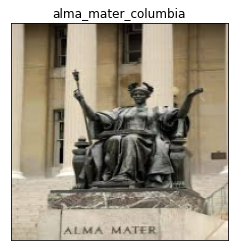

Prediction : butler_library_columbia  at  55.39  %


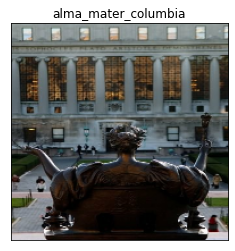

Prediction : alma_mater_columbia  at  74.66  %


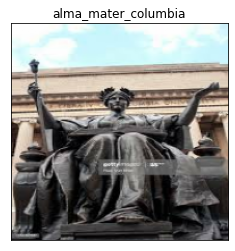

In [ ]:
for img,label in test_ds.take(10):

  K=np.random.randint(0,32)
  predictions=model.predict(img)
  predicted=np.array([np.argmax(predictions[i]) for i in range(len(predictions))])
  try:
    print("Prediction :",label_names[predicted[K]]," at ", np.round(np.max(predictions[K])*100,2)," %" )
    img=img[K]
    label=label_names[label[K]]
    show(img,label)
  except:
    break


# Using data augmentation

In [79]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale = 1./255,
    validation_split=0.2) #To create training / validation set with the same root directory

train_generator = train_datagen.flow_from_directory(
        data_root,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
      subset='training')

validation_generator = train_datagen.flow_from_directory(
    data_root, # same directory as training data
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation') # set as validation data

Found 256 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


Creating a 2nd model to train with data augmentation

In [80]:
# base_model = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(IMG_SIZE,IMG_SIZE,3),
#     pooling=None,
#     classes=1000,
# )
# base_model.trainable = False 

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# model = tf.keras.Sequential([
#   base_model,
#   global_average_layer,
#   prediction_layer
# ])
from keras.layers import Dropout,BatchNormalization

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 95, 95, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 144400)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 433203    
Total params: 433,651
Trainable params: 433,651
Non-trainable params: 0
_________________________________________________________________


In [81]:
history=model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // BATCH_SIZE,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // BATCH_SIZE,
      epochs = 15)

Epoch 1/15
8/8 [==============================] - 9s 1s/step - loss: 5.3833 - accuracy: 0.3711 - val_loss: 2.3738 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 8s 1s/step - loss: 2.7942 - accuracy: 0.5586 - val_loss: 1.1562 - val_accuracy: 0.6250
Epoch 3/15
8/8 [==============================] - 8s 1s/step - loss: 1.1288 - accuracy: 0.4336 - val_loss: 0.8798 - val_accuracy: 0.5938
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 0.9016 - accuracy: 0.5859 - val_loss: 1.0142 - val_accuracy: 0.5625
Epoch 5/15
8/8 [==============================] - 8s 1s/step - loss: 0.8762 - accuracy: 0.6172 - val_loss: 0.8386 - val_accuracy: 0.7188
Epoch 6/15
8/8 [==============================] - 8s 1s/step - loss: 0.7891 - accuracy: 0.7109 - val_loss: 0.8371 - val_accuracy: 0.7188
Epoch 7/15
8/8 [==============================] - 8s 1s/step - loss: 0.7623 - accuracy: 0.6680 - val_loss: 0.5276 - val_accuracy: 0.8125
Epoch 8/15
8/8 [=========================

3/3 - 5s - loss: 0.0514 - accuracy: 1.0000


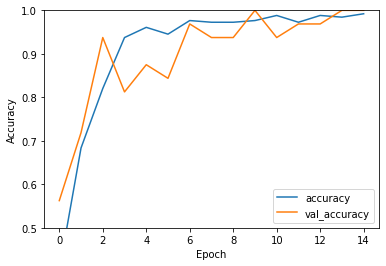

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

In [82]:
model.save("/content/columbia_landmarks_model.h5")
from google.colab import files
files.download("/content/columbia_landmarks_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>